# Frequency Response Function (FRF) Estimation
**Author:** Enej Podlipnik  
**Affiliation:** University of Ljubljana, Faculty of Mechanical Engineering  
**Date:** June 2024

This notebook is part of the diploma project "Impact Location and Force Prediction."  
For full context, see the repository.

## Purpose
This notebook demonstrates accelerometer data acquisition and FRF estimation using Welch's method.

It is intended for academic and non-commercial use.

## Requirements
- National Instruments hardware with NI-DAQmx drivers
- Python packages listed in requirements.txt

---

## 1. Imports and Setup

In [ ]:
import functions
import numpy as np
from scipy.signal import welch, coherence
import LDAQ
from nidaqmx.system import System
import matplotlib.pyplot as plt
import scipy.signal as signal
import os

## 2. Device Discovery

In [ ]:
system = System.local()
print(f"Devices: {[d.name for d in system.devices]}")

Devices: ['cDAQ3', 'cDAQ3Mod1']


## 3. Data Acquisition Setup

In [ ]:
# Build your NITask in code
input_task_1 = LDAQ.national_instruments.NITask(
    task_name="acc",
    sample_rate=51200
)
input_task_1.add_channel(
    channel_name="hammer",
    device_ind=1,
    channel_ind=0,
    sensitivity=2.273,
    sensitivity_units="mV/N",
    units="N"
)
input_task_1.add_channel(
    channel_name="pospeskomer_kot",
    device_ind=1,
    channel_ind=1,
    sensitivity=97.77,
    sensitivity_units="mV/g",
    units="g"
)

# Pass the NITask object, not the string name
acq = LDAQ.national_instruments.NIAcquisition(
    task_name=input_task_1,
    acquisition_name="acc_acq"
)

viz = LDAQ.Visualization()
viz.add_lines((0,0), source="acc_acq", channels=[0])  # Hammer
viz.add_lines((0,1), source="acc_acq", channels=[1])  # Accelerometer

viz.config_subplot((0,0), xlim=(-0.1, 0.5), ylim=(-20, 100))   # Adjust as needed for your signals
viz.config_subplot((0,1), xlim=(-0.1, 0.5), ylim=(-5, 5))

ldaq = LDAQ.Core(acquisitions=[acq], visualization=viz)
ldaq.set_trigger(
    source="acc_acq",
    channel="hammer",
    level=15,
    duration=0.3,
    presamples=100
)

## 4. Run Data Acquisition

In [ ]:
ldaq.run()
results = ldaq.get_measurement_dict()

In [ ]:
# Save the acquired data if needed
functions.save_model_results(dir_name="acc_data", file_name="acc_data_9", model_results_dict=results)

## 5. Frequency Response Function (FRF) Calculation

In [ ]:
def calculate_frf_welch(response, excitation, fs, nperseg=1024, noverlap=512):
    f, Paf = signal.csd(response, excitation, fs=fs, nperseg=nperseg, noverlap=noverlap)
    _, Pfa = signal.csd(excitation, response, fs=fs, nperseg=nperseg, noverlap=noverlap)
    _, Pff = signal.welch(excitation, fs=fs, nperseg=nperseg, noverlap=noverlap)
    _, Paa = signal.welch(response, fs=fs, nperseg=nperseg, noverlap=noverlap)
    H1 = Paf / Pff
    H2 = Paa / Pfa
    _, Coh = signal.coherence(response, excitation, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return f, H1, H2, Coh

In [ ]:
data_dir = "acc_data"
save_dir = "frf_results"
os.makedirs(save_dir, exist_ok=True)

# Storage for averaging
H1_list, H2_list, Coh_list = [], [], []

# Loop through all files
for fname in os.listdir(data_dir):
    if fname.endswith(".pkl"):
        # Load data
        results = functions.open_pkl_dict(os.path.join(data_dir, fname))
        t = results["acc_acq"]["time"]
        data = results["acc_acq"]["data"]
        # Only use the first 0.05 seconds
        mask = t <= 0.05
        excitation = data[mask, 0]  # hammer
        response = data[mask, 1]    # accelerometer
        fs = int(1 / (t[1] - t[0]))

        # Calculate FRF and coherence
        f, H1, H2, Coh = calculate_frf_welch(response, excitation, fs)

        # Save results
        frf_dict = {"f": f, "H1": H1, "H2": H2, "Coh": Coh}
        functions.save_model_results(save_dir, fname.replace(".pkl", ""), frf_dict)

        # Store for averaging
        H1_list.append(H1)
        H2_list.append(H2)
        Coh_list.append(Coh)

# Average FRFs and coherence
H1_avg = np.mean(np.abs(H1_list), axis=0)
H2_avg = np.mean(np.abs(H2_list), axis=0)
Coh_avg = np.mean(Coh_list, axis=0)

## 6. Visualization of Results

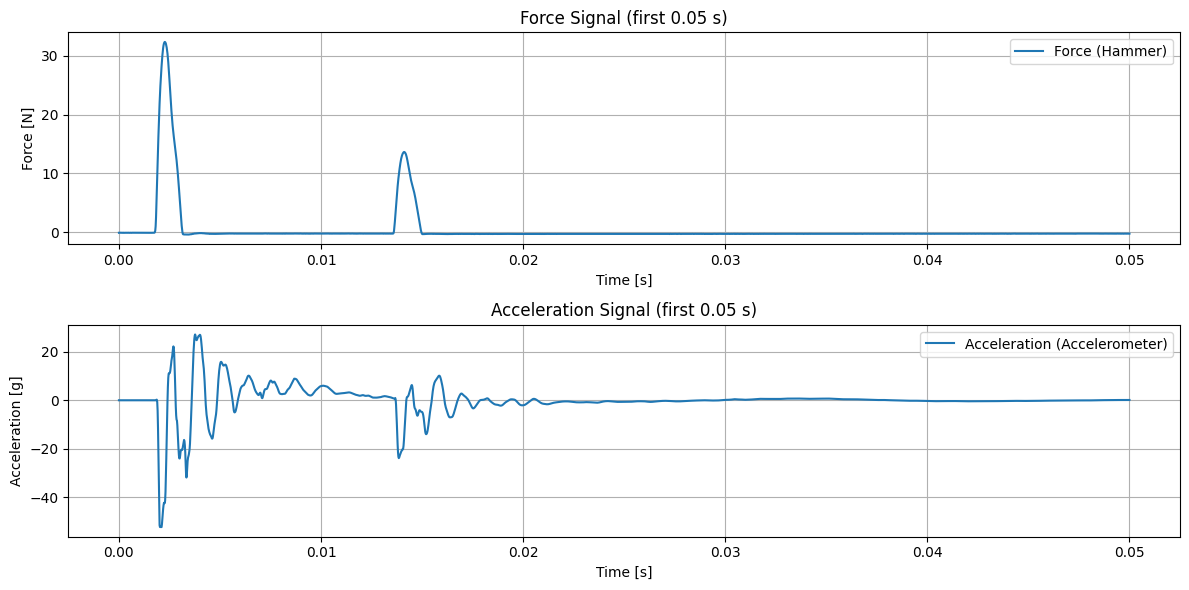

In [ ]:
# Plot the acc and force signal in relation to time (only first 0.05 seconds)
results = functions.open_pkl_dict(file_path="acc_data/acc_data_3.pkl")

t = results["acc_acq"]["time"]
data = results["acc_acq"]["data"]
force = data[:, 0]  # Hammer (force)
acc = data[:, 1]    # Accelerometer (acceleration)

# Mask for first 0.05 seconds
mask = t <= 0.05

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t[mask], force[mask], label="Force (Hammer)")
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.title("Force Signal (first 0.05 s)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t[mask], acc[mask], label="Acceleration (Accelerometer)")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [g]")
plt.title("Acceleration Signal (first 0.05 s)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

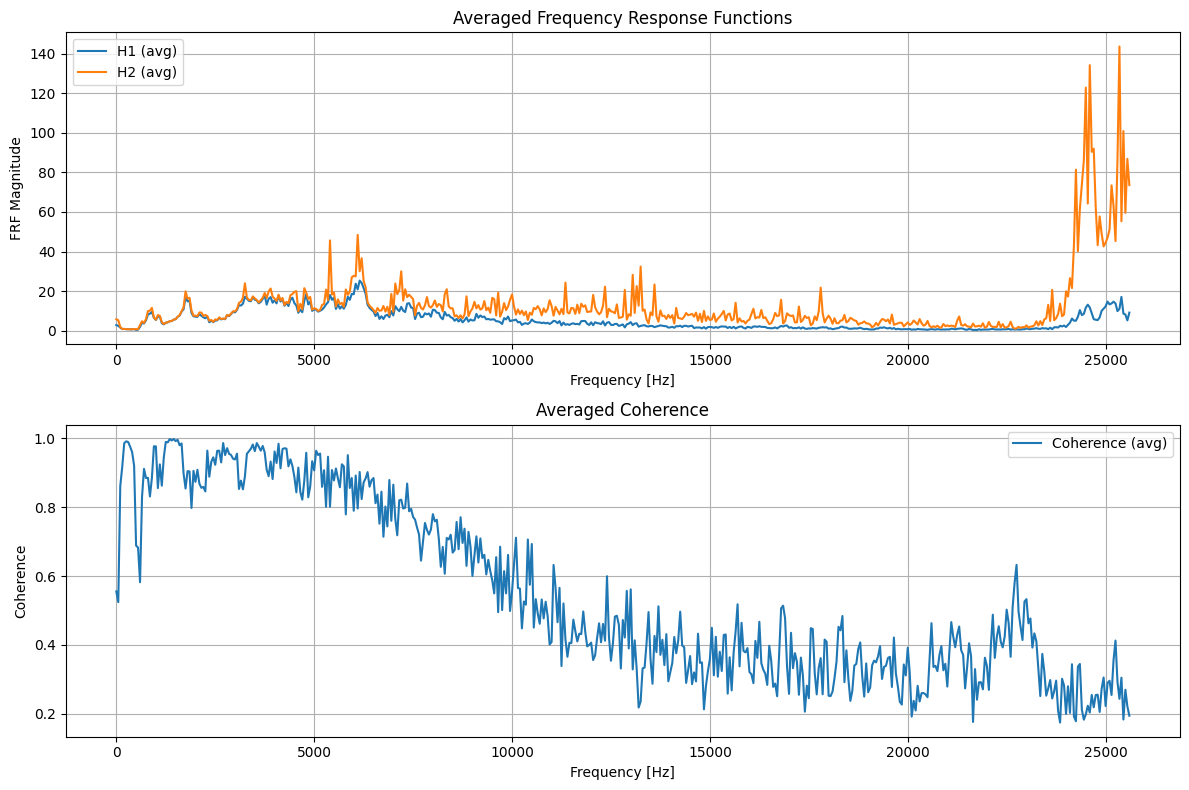

In [ ]:
# Plot H1, H2 and COH

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(f, H1_avg, label="H1 (avg)")
plt.plot(f, H2_avg, label="H2 (avg)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("FRF Magnitude")
plt.title("Averaged Frequency Response Functions")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(f, Coh_avg, label="Coherence (avg)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Coherence")
plt.title("Averaged Coherence")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

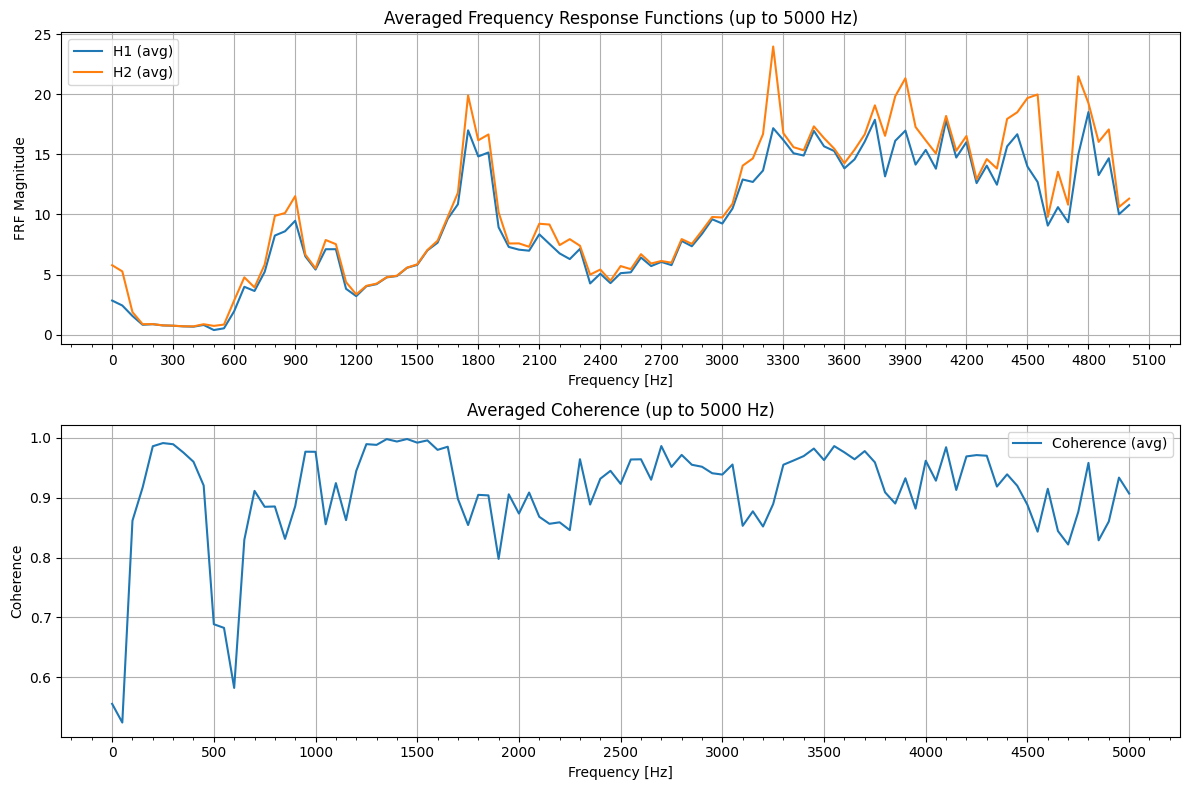

In [159]:
# Plot H1, H2 up to 5 kHz

import matplotlib.ticker as ticker

max_freq = 5000
freq_mask = f <= max_freq

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(f[freq_mask], H1_avg[freq_mask], label="H1 (avg)")
plt.plot(f[freq_mask], H2_avg[freq_mask], label="H2 (avg)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("FRF Magnitude")
plt.title("Averaged Frequency Response Functions (up to 5000 Hz)")
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(300))   # More ticks every 500 Hz
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(100))   # Minor ticks every 100 Hz

plt.subplot(2, 1, 2)
plt.plot(f[freq_mask], Coh_avg[freq_mask], label="Coherence (avg)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Coherence")
plt.title("Averaged Coherence (up to 5000 Hz)")
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(500))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(100))

plt.tight_layout()
plt.show()

## References
- This code is part of: Enej Podlipnik, "Impact Location and Force Prediction," Undergraduate Diploma Thesis, University of Ljubljana, Faculty of Mechanical Engineering, 2024.
- Repository: [add your repository URL here]